In [124]:
import tweepy #https://github.com/tweepy/tweepy
import csv
import pandas as pd 
import matplotlib as plt
from IPython.display import Image
import time
import datetime
import numpy as np
import urllib
import locale
import os
from IPython.display import HTML
from datetime import timedelta

%matplotlib inline

#Twitter API credentials from https://apps.twitter.com/
consumer_key = ""
consumer_secret = ""
access_key = ""
access_secret = ""


#def get_all_tweets(screen_name):
screen_name='@AusConservation'
#time difference to GMT - how many hours are you ahead of GMT
timedif=11

#report path
path='reports/'+screen_name+'/'
if not os.path.exists(path):
    os.makedirs(path)
#Twitter only allows access to a users most recent 3240 tweets with this method
#authorize twitter, initialize tweepy
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth)

In [125]:
#initialize a list to hold all the tweepy Tweets
alltweets = []	

#make initial request for most recent tweets (200 is the maximum allowed count)
new_tweets = api.user_timeline(screen_name = screen_name,count=200)

#save most recent tweets
alltweets.extend(new_tweets)

#save the id of the oldest tweet less one
oldest = alltweets[-1].id - 1

user = api.get_user(screen_name)
img=user.profile_image_url
a=urllib.urlretrieve(img,path+'logo.jpg')
name=user.name

In [126]:
#keep grabbing tweets until there are no tweets left to grab
while len(new_tweets) > 0:
    #print "getting tweets before %s" % (oldest)

    #all subsiquent requests use the max_id param to prevent duplicates
    new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest)

    #save most recent tweets
    alltweets.extend(new_tweets)

    #update the id of the oldest tweet less one
    oldest = alltweets[-1].id - 1

    print "...%s tweets downloaded so far" % (len(alltweets))

#transform the tweepy tweets into a 2D array that will populate the csv	
outtweets = [[tweet.id_str, 
              tweet.created_at, 
              tweet.text.encode('ascii', 'ignore'),
              tweet.retweet_count,
              tweet.favorite_count,
              tweet.entities,              
              '@'+tweet.user.screen_name] 
             if not (hasattr(tweet, 'retweeted_status')) else 
             [tweet.id_str, 
              tweet.created_at, 
              tweet.text.encode('ascii', 'ignore'),
              tweet.retweet_count,
              tweet.favorite_count,
              tweet.entities,
              '@'+tweet.retweeted_status.user.screen_name] for tweet in alltweets]
#write the csv
#with open('%s_tweets.csv' % screen_name, 'wb') as f:
#    writer = csv.writer(f)
#    writer.writerow(["id","created_at","text",'retweet','name'])
#    writer.writerows(outtweets)

pass

...398 tweets downloaded so far
...597 tweets downloaded so far
...765 tweets downloaded so far
...964 tweets downloaded so far
...1164 tweets downloaded so far
...1364 tweets downloaded so far
...1564 tweets downloaded so far
...1761 tweets downloaded so far
...1959 tweets downloaded so far
...2159 tweets downloaded so far
...2359 tweets downloaded so far
...2557 tweets downloaded so far
...2757 tweets downloaded so far
...2956 tweets downloaded so far
...3156 tweets downloaded so far
...3178 tweets downloaded so far
...3178 tweets downloaded so far


In [127]:
# save the tweet to file
df=pd.DataFrame(outtweets,columns=['id',"date","tweet",'# retweet','favored','ent','name'])
df['date']=(df['date']+timedelta(hours=timedif))
df['url']=df.ent.apply(lambda x: x['urls'][0]['expanded_url'] if len(x['urls'])>0 else None)
df['hashtag']=df.ent.apply(lambda x: '#'+x['hashtags'][0]['text'] if len(x['hashtags'])>0 else None)
df['photo']=df.ent.apply(lambda x: x['media'][0]['media_url'] if ('media' in x.keys()) else None)
dfr=df[df.name<>screen_name]
df=df[df.name==screen_name]
df[["date","tweet",'# retweet','favored','hashtag','url','photo']].to_csv(path+'tweets'+'.csv',index=False)
pd.set_option('max_colwidth',130) 
df.sort('# retweet',ascending=False).head(5)[['date','tweet','# retweet']]

,date,tweet,# retweet
978,2015-05-13 12:07:12,Did you know there's $13bn in #Budget2015 to subsidise mining companies' diesel? ACF's @kellyoshanassy @MattiLRose http://t.co...,195
1677,2014-11-15 15:46:42,That backfired! Try as he might @TonyAbbottMHR hasn't been able to keep #climatechange off the #G20Brisbane agenda http://t.co...,142
1555,2014-12-22 12:39:38,This morning Tony Abbott proved his views on climate (and women!) are stuck in the 50s. http://t.co/bW7vAewwXA http://t.co/3SK...,139
2719,2014-06-21 12:23:34,97% of Australians say our government should protect our World Heritage areas @UNESCO #Doha #MyWorldHeritage http://t.co/XzSym...,114
953,2015-05-18 20:11:01,Burning the lungs of our land isn't renewable. 'Biomass' shouldn't be in the #RET &gt; http://t.co/mZ8VWmlhVc http://t.co/AvPY...,105


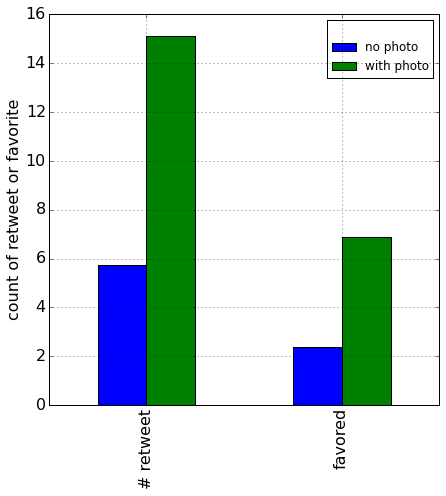

In [81]:
average=round(df['# retweet'].mean(),1)
maxret=df['# retweet'].max()
df[' ']=df.photo.apply(lambda x: 'no photo' if (x==None) else 'with photo')
ax=df.groupby(' ').mean().transpose().plot(kind='bar', fontsize=16,figsize=(7,7))
ax.set_xlabel('')
ax.set_ylabel('count of retweet or favorite',fontsize=16)
#ax.set_title('Average Retweet and Favorite for tweets with a photo\n',fontsize=20)
plt.pyplot.savefig(path+'photo.jpg')

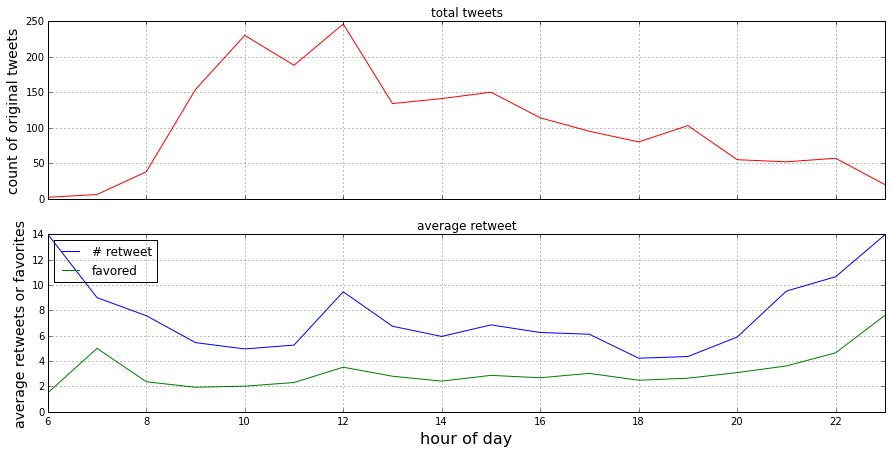

In [135]:
df = df.set_index(pd.to_datetime(df['date']))
fig, axes = plt.pyplot.subplots(nrows=2)
axes[1].set_xlabel("hour of day",fontsize=16)
axes[0].set_ylabel('count of original tweets',fontsize=14)
axes[1].set_ylabel('average retweets or favorites',fontsize=14)
df.groupby([df.index.hour])['id'].count().plot(ax=axes[0],figsize=(15,7),color='r',title='total tweets')
df.groupby([df.index.hour]).mean().plot(ax=axes[1],title='average retweet')
plt.pyplot.savefig(path+'timing.jpg')

In [71]:
# who are you retweeting
pd.set_option('max_colwidth',130) 
#dfr['last']=dfr.date.map(str)+'->'+dfr.tweet
dfr['last']=dfr.tweet
re_count=dfr.groupby('name')[['id']].count().sort('id',ascending=False)
re_text=dfr.groupby('name')[['last']].max().sort('last',ascending=False)
retweet=pd.DataFrame.join(re_count,re_text)
retweet.columns=['# tweets retweeted','last tweet retweeted']
retweet.to_csv(path+'retweets'+'.csv')
retweet.head(10).reset_index()

,name,# tweets retweeted,last tweet retweeted
0,@JoshMeadows3,146,"RT @JoshMeadows3: p 1 @guardian (UK). 'These are the most polluting coal, oil &amp; gas companies in the world. Are you helpin..."
1,@kellyoshanassy,60,RT @kellyoshanassy: Wonderful outcome for Australian culture and conservation https://t.co/GpGOco5zxK
2,@VictoriaMcKMcH,35,RT @VictoriaMcKMcH: With @jess_abrahams &amp; @AusConservation crew at the #peoplesclimate march. Tens of thousands in #Melbo...
3,@JonathanLaNauze,33,RT @JonathanLaNauze: Yes I approved Carmichael mine but I did site visit first and found it to be in remote barren landscape s...
4,@andrew_picone,29,RT @andrew_picone: Wuthathi country-Shelburne Bay #CapeYork. At @AusConservation we're hoping for a 2015 handback http://t.co/...
5,@Wilderness_Aus,29,"RT @Wilderness_Aus: Welcoming Ruth Langford. And she gets screams from the crowd. ""It is passionate which drives protection of..."
6,@bashastasak,20,RT @bashastasak: Wollongong Coal CEO &amp; COO resign not a good sign as company tries to expand #coal mine in #Sydney drinkin...
7,@jamescnorman,19,"RT @jamescnorman: Win for conservationists and traditional land owners Seeney ""will listen"" re CapeYork @andrew_picone @AusCon..."
8,@p_hannam,18,"RT @p_hannam: Timely reminder of what's behind power price rises - and it's not 'green schemes', from @jessradio: http://t.co/..."
9,@ClimateRealityA,17,RT @ClimateRealityA: This video tells the story of @TindoSolar #CinAU https://t.co/AQQ4oS5bhU


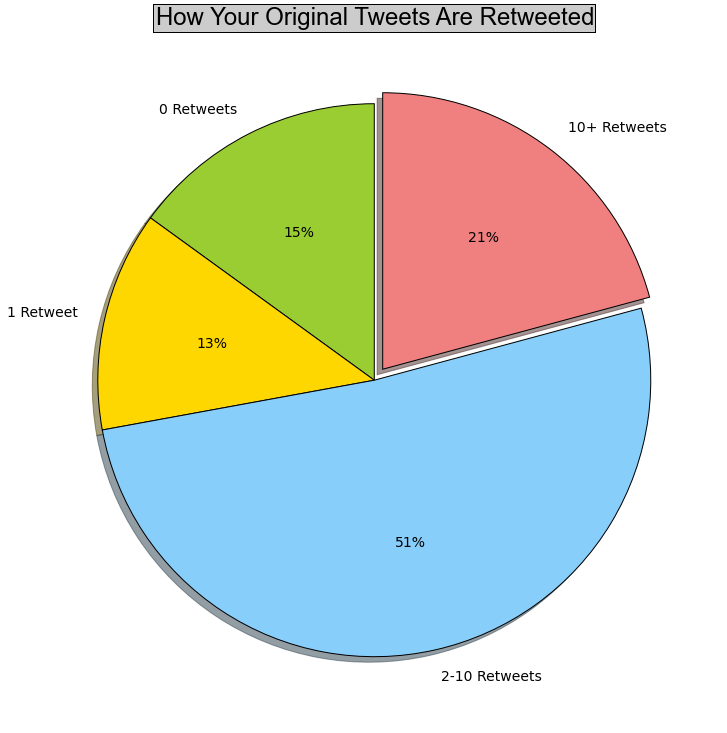

In [72]:
df.ix[df['# retweet']==0,'bin']='0 Retweets' 
df.ix[df['# retweet']==1,'bin']='1 Retweet' 
df.ix[(df['# retweet']>1) & (df['# retweet']<10) ,'bin']='2-10 Retweets' 
df.ix[df['# retweet']>=10,'bin']='10+ Retweets' 
fracs=df.groupby('bin').count().id.reindex(["0 Retweets", "1 Retweet", "2-10 Retweets",'10+ Retweets'])
labels=fracs.index
values=fracs.tolist()
explode=(0, 0, 0, 0.05)
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
plt.pyplot.figure(1, figsize=(12,12))
plt.pyplot.ax = plt.pyplot.axes([0.1, 0.1, 0.8, 0.8])
title_font = {'fontname':'Arial', 'size':'24', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
font = {'size'   : 14}
plt.rc('font', **font)

plt.pyplot.pie(values,explode,labels=labels,colors=colors,
    autopct='%1.0f%%', shadow=True, startangle=90)
plt.pyplot.title('How Your Original Tweets Are Retweeted', bbox={'facecolor':'0.8', 'pad':5},**title_font)
plt.pyplot.savefig(path+'tweets.jpg')
plt.pyplot.show()

In [ ]:
#download my retweeters
retweeters=[]
for id in df.id.head(240):
    try:
        retweeters = retweeters+api.retweets(id, count=100)
    except:
        time.sleep(15*60+1)
        retweeters = retweeters+api.retweets(id, count=100)    
retweeters_array=[]
for i in retweeters:
    retweeters_array=retweeters_array+[
        ['@'+i.user.screen_name,
         i.user.followers_count,
         i.created_at,
         i.text.encode('ascii', 'ignore')]]

In [88]:
#find biggest retweeters
retweeters_df=pd.DataFrame(retweeters_array,columns=['name','followers','created_at','text'])
#retweeters_df['last']=retweeters_df.created_at.map(str)+'->'+retweeters_df.text
retweeters_df['last']=retweeters_df.text
retweeter_count=retweeters_df.groupby('name')[['text']].count().sort('text', ascending=False)
retweeter_text=retweeters_df.groupby('name')[['followers','last']].max()
retweeter=pd.DataFrame.join(retweeter_count,retweeter_text)
retweeter.columns=['# tweets retweeted','# followers','last tweet retweeted']
retweeter.to_csv(path+'retweeters'+'.csv')
retweeter.head(20).reset_index()

,name,# tweets retweeted,# followers,last tweet retweeted
0,@parksmovement,30,276,RT @AusConservation: Two former SA senators giving evidence now to Committee in Adelaide #DefendEnviroOrgs
1,@DrRimmer,26,8807,RT @AusConservation: http://t.co/t5F5d6oHIu http://t.co/a5T1Pv7wnN
2,@FoEAustralia,24,9563,RT @AusConservation: Whitehaven Coal tells #HoR inquiry of its own political campaigning with @MineralsCouncil #DefendEnviroOr...
3,@CounterActOz,22,1021,RT @AusConservation: You cant even knock on the door of philanthropy without DGR status says Jonathan Duddles from @GreeningAu...
4,@enviroaus,18,65,RT @AusConservation: We've been audited twice in the last year and passed both says @Cam_Walker from @FoEAustralia #DefendEnvi...
5,@AusBackwards,14,80,RT @AusConservation: We need to talk about climate change as a profound moral crisis @NaomiAKlein @MelbWritersFest
6,@wannoncan,13,84,RT @AusConservation: We are not going to get an agreement in Paris that is in line with what the science says we need @NaomiAK...
7,@MareeTreadwellK,13,873,RT @AusConservation: You cant even knock on the door of philanthropy without DGR status says Jonathan Duddles from @GreeningAu...
8,@csrlagos,12,158,RT @AusConservation: Tweets from House of Reps inquiry into environment groups Adelaide hearing to follow... https://t.co/XpOQ...
9,@CloudsCreek,12,2801,RT @AusConservation: We need to talk about climate change as a profound moral crisis @NaomiAKlein @MelbWritersFest


In [89]:
# download all followers
followers_ids = []
for page in tweepy.Cursor(api.followers_ids, screen_name).pages():
    followers_ids.extend(page)
followers=[]
chunks=[followers_ids[x:x+100] for x in xrange(0,len(followers_ids), 100)]
i=0
for id100 in chunks:
    i=i+1
    try:
        users = api.lookup_users(user_ids=id100)
        followers=followers+[
            [#u.name.encode('ascii', 'ignore'), 
             '@'+u.screen_name.encode('ascii', 'ignore'),
             u.followers_count,
             u.friends_count,
             u.location.encode('ascii', 'ignore'),
             'https://twitter.com/'+u.screen_name.encode('ascii', 'ignore')] for u in users]
        if i%10==0 :
            print i*100,'followers downloaded so far'
    except:
        print 'you reached the api call limit! the program will countinou after 15 minutes ...'
        print datetime.datetime.now()
        print ''
        time.sleep(15*60+1)
        users = api.lookup_users(user_ids=id100)
        followers=followers+[
            [#u.name.encode('ascii', 'ignore'), 
             '@'+u.screen_name.encode('ascii', 'ignore'),
             u.followers_count,
             u.friends_count,
             u.location.encode('ascii', 'ignore'),
             'https://twitter.com/'+u.screen_name.encode('ascii', 'ignore')] for u in users]
        if i%10==0 :
            print i*100,'followers downloaded so far'

1000 followers downloaded so far
2000 followers downloaded so far
3000 followers downloaded so far
4000 followers downloaded so far
5000 followers downloaded so far
6000 followers downloaded so far
7000 followers downloaded so far
8000 followers downloaded so far
9000 followers downloaded so far
10000 followers downloaded so far
11000 followers downloaded so far
12000 followers downloaded so far
13000 followers downloaded so far
14000 followers downloaded so far
15000 followers downloaded so far
16000 followers downloaded so far
17000 followers downloaded so far
18000 followers downloaded so far
you reached the api call limit! the program will countinou after 15 minutes ...
2015-10-12 12:07:43.990000



In [94]:
followers_df=pd.DataFrame(followers,columns=('name','# followers','followees','location','link'))
followers_df['ratio']=followers_df['# followers']/followers_df.followees
followers_df.sort('# followers',ascending=False).to_csv(path+'followers'+'.csv',index=False)

In [95]:
followers_df[followers_df.ratio>5].sort('# followers',ascending=False)[['name','# followers','location','link','ratio']].head(20)

,name,# followers,location,link,ratio
18568,@BarackObama,64826646,"Washington, DC",https://twitter.com/BarackObama,101.327257
15512,@UNICEF,4728744,United Nations,https://twitter.com/UNICEF,188.291152
3651,@NelsonMandela,1188586,"Houghton, South Africa",https://twitter.com/NelsonMandela,51.327288
18008,@emergency_ong,480937,"Italy, HQ",https://twitter.com/emergency_ong,88.750138
18436,@nature_org,468667,"T: 38.883103,-77.110875",https://twitter.com/nature_org,14.501733
18406,@TurnbullMalcolm,456998,"Sydney, NSW, Australia",https://twitter.com/TurnbullMalcolm,101.962963
17778,@NWF,373152,"Washington, DC",https://twitter.com/NWF,8.961814
16171,@sunriseon7,355152,Sydney,https://twitter.com/sunriseon7,12.008115
16948,@guardianeco,345839,"London, UK",https://twitter.com/guardianeco,42.026856
18083,@CadelOfficial,328027,Australia/Switzerland,https://twitter.com/CadelOfficial,1079.036184


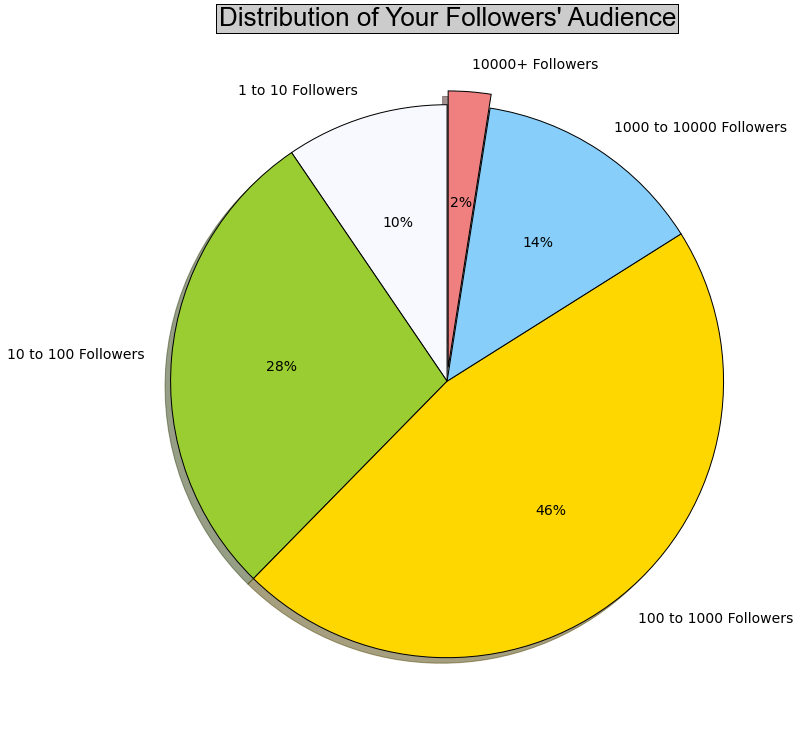

In [96]:
followers_df.ix[followers_df['# followers']<=10,'bin']='1 to 10 Followers' 
followers_df.ix[(followers_df['# followers']>10) & (followers_df['# followers']<=100) ,'bin']='10 to 100 Followers' 
followers_df.ix[(followers_df['# followers']>100) & (followers_df['# followers']<=1000) ,'bin']='100 to 1000 Followers' 
followers_df.ix[(followers_df['# followers']>1000) & (followers_df['# followers']<=10000),'bin']='1000 to 10000 Followers' 
followers_df.ix[followers_df['# followers']>10000,'bin']='10000+ Followers' 
fracs=followers_df.groupby('bin').count().name
labels=fracs.index
explode=(0, 0, 0, 0, 0.05)
colors = ['GhostWhite','yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
plt.pyplot.figure(1, figsize=(12,12))
plt.pyplot.ax = plt.pyplot.axes([0.1, 0.1, 0.8, 0.8])
title_font = {'fontname':'Arial', 'size':'26', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
font = {'size'   : 14}
plt.rc('font', **font)

plt.pyplot.pie(fracs,explode,labels=labels,colors=colors,
    autopct='%1.0f%%', shadow=True, startangle=90)
plt.pyplot.title('''Distribution of Your Followers' Audience''', bbox={'facecolor':'0.8', 'pad':5},**title_font)
plt.pyplot.savefig(path+'followers.jpg')
plt.pyplot.show()

In [129]:
topret=df.reset_index(drop=True).sort('# retweet',ascending=False).head(5)[['date','tweet','# retweet']]
topret['date']=topret.date.apply(lambda x:x.strftime("%d/%m/%Y"))
retfrom=retweet.reset_index().head(10)
retfrom['name'] = retfrom['name'].apply(lambda x: '<a href="https://twitter.com/'+x+'" target="_blank">'+x+'</a>')
topfol=followers_df[['name','# followers','location','link']].head(10)
topfol['name'] = topfol['name'].apply(lambda x: '<a href="https://twitter.com/'+x+'" target="_blank">'+x+'</a>')
followers_df=followers_df[followers_df.ratio>5].sort('# followers',ascending=False)[['name','# followers','location','link','ratio']].head(20)
reter=retweeter.head(10).reset_index()
reter['name'] = reter['name'].apply(lambda x: '<a href="https://twitter.com/'+x+'" target="_blank">'+x+'</a>')

In [130]:
#locale.setlocale(locale.LC_ALL, 'en_US')
year=user.created_at.year
month=user.created_at.strftime("%B")
#total_tweets=locale.format("%d", user.statuses_count, grouping=True)
total_tweets='{0:,}'.format(user.statuses_count)
#total_followers=locale.format("%d", user.followers_count, grouping=True)
total_followers='{0:,}'.format(user.followers_count)
today=time.strftime("%d/%m/%Y")
topret=topret.to_html(index=False, classes='table table-striped')
retfrom=retfrom.to_html(index=False, classes='table table-striped', escape=False)
topfol=topfol.to_html(index=False, classes='table table-striped',escape=False)
reter=reter.to_html(index=False, classes='table table-striped',escape=False)

In [137]:
from jinja2 import Environment, FileSystemLoader
import os

# Capture our current directory

j2_env = Environment(loader=FileSystemLoader(''),trim_blocks=True)

x=j2_env.get_template('template.html').render(
    name=name,
    screen_name=screen_name,
    year=year,
    month=month,
    total_tweets=total_tweets,
    total_followers=total_followers,
    today=today,
    average=average,
    maxret=maxret,
    topret=topret,
    time_tweet='between 9AM to 7PM',
    time_retweet='late night or early morning',
    photo='two times',
    retfrom=retfrom,
    topfol=topfol,
    reter=reter
)
f = open('reports/'+screen_name+'/report.html','w')
f.write(x) # python will convert \n to os.linesep
f.close() 
import webbrowser
new = 2 # open in a new tab, if possible

# open a public URL, in this case, the webbrowser docs
url = "file:///C:/Users/moqri/Google%20Drive/Research/Social%20Media/Analysis/user/reports/@AusConservation/report.html"
webbrowser.get('chrome').open(url,new=new)

True

In [112]:
webbrowser.register('chrome', None, webbrowser.GenericBrowser('C:\\Program Files (x86)\\Google\\Chrome\\Application\\chrome.exe'))
